Target variables for ML:


    % fatality 
    
    Shooter killed
    
    Mass

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
from itertools import combinations
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [32]:
#df = pd.read_csv('/home/jklingl/capstone/capstone_ML_data_grade_not_percentage')
df = pd.read_csv('/home/jklingl/capstone/school_safety_with_extra_data_gini_update_1.csv')

/home/jklingl/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (39,188,566,568,571,572,576,577,593,600,1219,1220,1223,1224,1225,1226,1229) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [34]:
grade_columns = [
    'NCES_Grade_PK', 'NCES_Grade_KG', 'NCES_Grade_1', 'NCES_Grade_2', 'NCES_Grade_3',
    'NCES_Grade_4', 'NCES_Grade_5', 'NCES_Grade_6', 'NCES_Grade_7', 'NCES_Grade_8',
    'NCES_Grade_9', 'NCES_Grade_10', 'NCES_Grade_11', 'NCES_Grade_12'
]

# Define a list of grade levels corresponding to the columns (PK = 0, KG = 0.5, 1st = 1, ..., 12th = 12)
grade_levels = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Calculate the weighted sum of grade levels and the total students
weighted_sum = df[grade_columns].multiply(grade_levels, axis=1).sum(axis=1)
total_students = df[grade_columns].sum(axis=1)

# Calculate the average grade level for each row
# If the total number of students is zero, set average grade level to NaN
df['Avg_Grade_Level'] = np.where(total_students > 0, weighted_sum / total_students, np.nan)

In [35]:
columns_to_include = [
    'NCES_Grade_PK', 'NCES_Grade_KG', 'NCES_Grade_1',
    'NCES_Grade_2', 'NCES_Grade_3', 'NCES_Grade_4',
    'NCES_Grade_5', 'NCES_Grade_6', 'NCES_Grade_7',
    'NCES_Grade_8', 'NCES_Grade_9', 'NCES_Grade_10',
    'NCES_Grade_11', 'NCES_Grade_12'
]

# Calculate the standard deviation for the specified columns in each row
df['Std_Dev_Grade_Level'] = df[columns_to_include].std(axis=1, ddof=0)

In [36]:
columns = [
    'NCES_Grade_PK', 'NCES_Grade_KG', 'NCES_Grade_1', 'NCES_Grade_2', 'NCES_Grade_3',
    'NCES_Grade_4', 'NCES_Grade_5', 'NCES_Grade_6', 'NCES_Grade_7', 'NCES_Grade_8',
    'NCES_Grade_9', 'NCES_Grade_10', 'NCES_Grade_11', 'NCES_Grade_12','Avg_Grade_Level'
    ,'Std_Dev_Grade_Level','Std_Dev_Specified_Columns'
]

In [37]:
# created mass column and converted str to ints for the others
df['Mass'] = df['Number_Victims']>2
df['Mass'] = df['Mass'].astype(int)
df['Accidental_Flag'] = (df['Situation'] == 'Accidental').astype(int)
df['During_Classes'] = df['During_Classes'].replace({'Yes': 1, 'No': 0,'Unknown':2,'NO':0,'N':0})
df['Hostages'] = df['Hostages'].replace({'Yes': 1, 'No': 0,'Unknown':2,'NO':0,'N':0})
df['Barricade'] = df['Barricade'].replace({'Yes': 1, 'No': 0,'Unknown':2,'NO':0,'N':0})
df['Officer_Involved'] = df['Officer_Involved'].replace({'Yes': 1, 'No': 0,'Unknown':2,'NO':0,'N':0})
df['Active_Shooter_FBI'] = df['Active_Shooter_FBI'].replace({'Yes': 1, 'No': 0,'Unknown':2,'NO':0,'N':0})
replacement_dict = {
    'Elementary': 1,
    'Middle': 2,
    'High': 3,
    'K-12': 4,
    'K-8': 5,
    'Junior High': 2,
}

# Replace the values in the 'School_Level' column according to the dictionary
# and turn all other values to NaN
df['School_Level'] = df['School_Level'].replace(replacement_dict)

# Convert any remaining values to NaN
df['School_Level'] = df['School_Level'].where(df['School_Level'].isin(replacement_dict.values()))

In [38]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

In [40]:
# Get all column names that do not contain the specified keywords
excluded_columns = [col for col in df.columns if any(keyword in col for keyword in ["Immigration","Ancestry", "Race", "School_Enrollment", "NCES_School"])]

# Create a subset of the DataFrame without the excluded columns
subset_df = df.drop(columns=excluded_columns)

In [41]:
correlations = subset_df.corr()[['%_Fatality']].drop(index=['%_Fatality'])

# Sort correlations by absolute value
sorted_correlations = correlations.sort_values(by='%_Fatality', ascending=False)

# Display sorted correlations
sorted_correlations.head(50)

,%_Fatality
Victims_Killed,0.484112
Employment_Industries_Female_Public_Administration,0.085801
Household_Vehicle_Usage_Owner_Occupied_No_Vehicle,0.081818
Real_Estate_Taxes_By_Mortgage_Status_With_Mortgage_Less_Than_800,0.080489
Income_Below_Poverty_Among_Single_Parent_Households_Single_Father_1_Or_2_Children,0.077515
Number_Victims,0.077302
Commute_Time_By_Sex_30_34_Minutes_Female,0.075168
Employment_Service_Occupations_By_Sex_Female_Firefighting_Prevention,0.074620
Commute_Time_By_Sex_40_44_Minutes_Female,0.071327
Employment_Occupations_By_Sex_Female_Legal_Services_Support,0.071298


In [75]:
all_features = sorted_correlations.head(50).index.tolist()

In [47]:
# features to predict if shooter was killed
feature_columns_shooter_orig = ['NCES_American_Indian_Alaska_Native','NCES_Asian','NCES_Black','NCES_Hispanic',
                  'NCES_Native_Hawaiian_Pacific_Islander','NCES_Two_Or_More_Races','NCES_Male','NCES_Female',
                  'Avg_Grade_Level','Victims_Killed', 'Victims_Wounded', 'Number_Victims', 'Number_News',
                  'Reliability', 'During_Classes','Duration_min','Accomplice', 'Hostages','Barricade', 
                  'Officer_Involved', 'Bullied', 'Domestic_Violence', 'Gang_Related', 
                  'Active_Shooter_FBI', 'Shots_Fired', 'Zip_Code','Mass','Accidental_Flag','Std_Dev_Grade_Level'

]

In [48]:
# features to predict fatality
feature_columns_per_fatality_orig = ['NCES_American_Indian_Alaska_Native','NCES_Asian','NCES_Black','NCES_Hispanic',
                  'NCES_Native_Hawaiian_Pacific_Islander','NCES_Two_Or_More_Races','NCES_Male','NCES_Female',
                  'Avg_Grade_Level','Victims_Wounded', 'Number_Victims', 'Number_News','Shooter_Killed',
                  'Reliability', 'During_Classes','Duration_min','Accomplice', 'Hostages','Barricade', 
                  'Officer_Involved', 'Bullied', 'Domestic_Violence', 'Gang_Related', 
                  'Active_Shooter_FBI', 'Shots_Fired', 'Zip_Code','Mass','Accidental_Flag','Std_Dev_Grade_Level'

]

In [49]:
# if wanted to predict size of shooting (predicting Number wounded) - keep shooter killed/take out all about victims
feature_columns_pred_wounded_orig = ['NCES_American_Indian_Alaska_Native','NCES_Asian','NCES_Black','NCES_Hispanic',
                  'NCES_Native_Hawaiian_Pacific_Islander','NCES_Two_Or_More_Races','NCES_Male','NCES_Female',
                  'Avg_Grade_Level','Number_News','Shooter_Killed',
                  'Reliability', 'During_Classes','Duration_min','Accomplice', 'Hostages','Barricade', 
                  'Officer_Involved', 'Bullied', 'Domestic_Violence', 'Gang_Related', 
                  'Active_Shooter_FBI', 'Shots_Fired', 'Zip_Code','Mass','Accidental_Flag','Std_Dev_Grade_Level'

]

In [50]:
def find_non_numeric_columns(df):
    non_numeric_columns = []
    for column in df.columns:
        try:
            # Attempt to convert the column values to floats
            df[column].astype(float)
        except ValueError as e:
            # If conversion fails, add the column name to the list
            non_numeric_columns.append(column)
    return non_numeric_columns

# Find columns with non-numeric values
non_numeric_columns = find_non_numeric_columns(df
                                               [feature_columns_per_fatality_orig])
print(f"Columns with non-numeric values: {non_numeric_columns}")

Columns with non-numeric values: ['NCES_American_Indian_Alaska_Native', 'NCES_Asian', 'NCES_Black', 'NCES_Hispanic', 'NCES_Native_Hawaiian_Pacific_Islander', 'NCES_Two_Or_More_Races', 'NCES_Male', 'NCES_Female', 'Accomplice', 'Bullied', 'Domestic_Violence', 'Gang_Related', 'Shots_Fired']


In [51]:
for column in non_numeric_columns:
    # Convert non-numeric values to NaN (or handle them as desired)
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [52]:
df2 = df.fillna(0)

In [77]:
# For feature selection

#define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
#X = df2[final_features_fatality]
#X = df2[feature_columns_per_fatality_orig]
X = df2[all_features]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees in the model
    max_depth=6,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate (shrinkage)
    random_state=0  # Random state for reproducibility
)


In [79]:
# Get the indices of the first 10 rows
first_10_indices = sorted_correlations.head(10).index.tolist()

next_10_indices = sorted_correlations.index[10:20].tolist()

last_10_indices = sorted_correlations.index[20:30].tolist()

Final_10_indices = sorted_correlations.index[30:40].tolist()

# Combine the lists into a single list of lists
result = [first_10_indices, next_10_indices, last_10_indices]

In [80]:
fs = [feat for feat in Final_10_indices]
important_features2 = []

# Dictionary to store feature and its score
feature_scores = {}

while len(fs) > 0:
    if len(fs) == 1:
        important_features2.insert(0, fs[0])
        break
    res = []
    for comb in combinations(Final_10_indices, len(fs) - 1):
        missing = [_ for _ in fs if _ not in list(comb)][0]
        comb = list(comb)
        xgb_model.fit(X_train[comb], y_train)
        score = xgb_model.score(X_val[comb], y_val)
        res.append((missing, score))
        # Storing feature and its score in the dictionary
        feature_scores[missing] = score
    least_important = max(res, key=lambda t: t[1])[0]
    important_features2.insert(0, least_important)
    fs.remove(least_important)

# Sort feature_scores dictionary by values (scores) in descending order
sorted_features = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)

# Extract top 5 features based on their scores
top_5_features = [feat for feat, _ in sorted_features[:5]]

print("Top 5 features based on scores:", top_5_features)

Top 5 features based on scores: ['Household_Type_Single_Female_Mother_Number_Of_Households', 'Income_Above_Poverty_By_Sex_&_Age_Female_25_34_Years', 'Family_Type_Single_Female_Mother_Number_Of_Families', 'Public_VS_Private_Health_Insurance_Public_Insurance_Under_6_Years', 'Sex_And_Age_Female_30_To_34_Years']


In [82]:
final_features_fatality = ['Employment_Occupations_By_Sex_Female_Legal_Services_Support', 
                  'Commute_Time_By_Sex_40_44_Minutes_Female', 
                  'Commute_Time_By_Sex_30_34_Minutes_Female', 
                  'Household_Vehicle_Usage_Owner_Occupied_No_Vehicle', 
                  'Employment_Service_Occupations_By_Sex_Female_Firefighting_Prevention',
                 'Housing_Structures_Number_Housing_Units_Single_Unit_Attached', 
                  'Employment_Status_By_Age_45_54_Years_Unemployed', 
                  'Employment_Status_By_Educational_Attainment_High_School_Diploma_Unemployed', 
                  'Employment_Status_By_Age_35_44_Years_Unemployed', 
                  'Housing_Structures_By_Number_Of_Rooms_Owner_Occupied_2_3_Room',
                  'Vehicle_Availability_By_Sex_Female_1_Vehicle', 
                  'Employment_Service_Occupations_By_Sex_Female_Security_Protection', 
                  'Monthly_Housing_Cost_Tiers_Renter_Occupied_2500_2999', 
                  'Housing_Structures_By_Occupancy_Number_Housing_Units_Single_Unit_Attached_Owner_Occupied', 
                  'Sex_And_Age_Male_35_To_39_Years', 
                  'Employment_Status_By_Age_25_29_Years_Unemployed', 
                  'Public_VS_Private_Health_Insurance_Public_Insurance_Under_6_Years', 
                  'Monthly_Housing_Cost_Tiers_Renter_Occupied_1500_1999', 
                  'Sex_And_Age_Female_30_To_34_Years', 
                  'Occupany_By_Householder_Income_Bracket_Renter_Occupied_150000_+',
                  'NCES_American_Indian_Alaska_Native','NCES_Asian','NCES_Black','NCES_Hispanic',
                  'NCES_Native_Hawaiian_Pacific_Islander','NCES_Two_Or_More_Races','NCES_Male','NCES_Female',
                  'Avg_Grade_Level','Victims_Wounded', 'Number_Victims', 'Number_News','Shooter_Killed',
                  'Reliability', 'During_Classes','Duration_min','Accomplice', 'Hostages','Barricade', 
                  'Officer_Involved', 'Bullied', 'Domestic_Violence', 'Gang_Related', 
                  'Active_Shooter_FBI', 'Shots_Fired', 'Zip_Code','Mass','Accidental_Flag','Std_Dev_Grade_Level'

]

In [83]:
final_features_shooter = ['Employment_Occupations_By_Sex_Female_Legal_Services_Support', 
                  'Commute_Time_By_Sex_40_44_Minutes_Female', 
                  'Commute_Time_By_Sex_30_34_Minutes_Female', 
                  'Household_Vehicle_Usage_Owner_Occupied_No_Vehicle', 
                  'Employment_Service_Occupations_By_Sex_Female_Firefighting_Prevention',
                 'Housing_Structures_Number_Housing_Units_Single_Unit_Attached', 
                  'Employment_Status_By_Age_45_54_Years_Unemployed', 
                  'Employment_Status_By_Educational_Attainment_High_School_Diploma_Unemployed', 
                  'Employment_Status_By_Age_35_44_Years_Unemployed', 
                  'Housing_Structures_By_Number_Of_Rooms_Owner_Occupied_2_3_Room',
                  'Vehicle_Availability_By_Sex_Female_1_Vehicle', 
                  'Employment_Service_Occupations_By_Sex_Female_Security_Protection', 
                  'Monthly_Housing_Cost_Tiers_Renter_Occupied_2500_2999', 
                  'Housing_Structures_By_Occupancy_Number_Housing_Units_Single_Unit_Attached_Owner_Occupied', 
                  'Sex_And_Age_Male_35_To_39_Years', 
                  'Employment_Status_By_Age_25_29_Years_Unemployed', 
                  'Public_VS_Private_Health_Insurance_Public_Insurance_Under_6_Years', 
                  'Monthly_Housing_Cost_Tiers_Renter_Occupied_1500_1999', 
                  'Sex_And_Age_Female_30_To_34_Years', 
                  'Occupany_By_Householder_Income_Bracket_Renter_Occupied_150000_+',
                  'NCES_American_Indian_Alaska_Native','NCES_Asian','NCES_Black','NCES_Hispanic',
                  'NCES_Native_Hawaiian_Pacific_Islander','NCES_Two_Or_More_Races','NCES_Male','NCES_Female',
                  'Avg_Grade_Level','Victims_Killed', 'Victims_Wounded', 'Number_Victims', 'Number_News',
                  'Reliability', 'During_Classes','Duration_min','Accomplice', 'Hostages','Barricade', 
                  'Officer_Involved', 'Bullied', 'Domestic_Violence', 'Gang_Related', 
                  'Active_Shooter_FBI', 'Shots_Fired', 'Zip_Code','Mass','Accidental_Flag','Std_Dev_Grade_Level']

## Multi-Linear Model

## To test for accuracy

Regression --- Use MSE and R^2

Classification --- Use accuracy score lib from sklearn

In [114]:
# stats from the new feature list

# Define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
X = df2[feature_columns_per_fatality_orig]
#X = df2[final_features_fatality]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Create a LinearRegression model
model = LinearRegression()

# Fit the model using the training data
model.fit(X_train, y_train)


# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate mean squared error on the validation set
val_mse = mean_squared_error(y_val, y_val_pred)

# Calculate R-squared on the validation set
val_r2 = r2_score(y_val, y_val_pred)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate mean squared error on the test set
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared on the test set
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics for the validation set
print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R-squared: {val_r2}')

# Print the evaluation metrics for the validation set
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test R-squared: {test_r2}')

Validation Mean Squared Error: 0.08393579698681194
Validation R-squared: 0.3706759643247578
Test Mean Squared Error: 0.08930181054355613
Test R-squared: 0.3991403910269766


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the dependent (target) variable
target_column = 'Shooter_Killed'  # Replace 'your_target_column' with the name of your target column

# Split data into features (X) and target (y)
#X = df2[final_features_shooter]
X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Split the test data further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# Create a LogisticRegression model
model = LogisticRegression(random_state=0, class_weight = 'balanced')

# Fit the model using the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)


# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)



# Print the evaluation metrics for the test set
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print(f'Test Confusion Matrix:\n{test_confusion_matrix}')
print(f'Test Mean Squared Error (MSE): {test_mse:.4f}')


# Print the evaluation metrics for the validation set
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1-Score: {val_f1:.4f}')
print(f'Validation Confusion Matrix:\n{val_confusion_matrix}')
print(f'Val Mean Squared Error (MSE): {val_mse:.4f}')

Test Accuracy: 0.4272
Test Precision: 0.8775
Test Recall: 0.4272
Test F1-Score: 0.5477
Test Confusion Matrix:
[[196 176  92]
 [  8  24  19]
 [  0   0   0]]
Test Mean Squared Error (MSE): 1.1087
Validation Accuracy: 0.4086
Validation Precision: 0.8680
Validation Recall: 0.4086
Validation F1-Score: 0.5191
Validation Confusion Matrix:
[[180 189  92]
 [  8  30  14]
 [  1   0   0]]
Val Mean Squared Error (MSE): 1.1342


/home/jklingl/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jklingl/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
df['Shooter_Killed'].describe()

count    2572.000000
mean        0.093701
std         0.295446
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Shooter_Killed, dtype: float64

## Neural Network Model

In [127]:
# Define the dependent (target) variable
target_column = 'Shooter_Killed'

# Define the independent (feature) variables


# Split data into features (X) and target (y)
X = df2[final_features_shooter]
#X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Changing weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# Convert class weights to dictionary
class_weights_dict = dict(enumerate(class_weights))

# Create a LinearRegression model
model = Sequential()

# Input layer (number of neurons = number of features)
model.add(Dense(units=64, input_shape=(X_train.shape[1],), activation='relu'))

# Hidden layer
model.add(Dense(units=32, activation='relu'))

# Output layer (single neuron for regression)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Fit the model using the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,class_weight = class_weights_dict)

val_loss,val_accuracy = model.evaluate(X_val, y_val)

#test_loss,test_accuracy = model.evaluate(X_test, y_test)

# val_mse = mean_squared_error(y_val, y_val_pred)


print(f'Validation Loss (Binary Cross-Entropy): {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
# print(f'Validation MSE: {val_mse:.4f}')


# print(f'Test Loss (Binary Cross-Entropy): {test_loss:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/100


/home/jklingl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=5       0
55      0
1116    0
987     0
511     0
       ..
1033    0
1731    0
763     0
835     0
1653    1
Name: Shooter_Killed, Length: 1543, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


39/39 [==============================] - 1s 5ms/step - loss: 0.4564 - accuracy: 0.4595 - val_loss: 0.7079 - val_accuracy: 0.5340
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.5470 - val_loss: 0.7123 - val_accuracy: 0.5793
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: -0.0668 - accuracy: 0.6410 - val_loss: 0.6627 - val_accuracy: 0.6602
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: -0.2703 - accuracy: 0.6750 - val_loss: 0.6742 - val_accuracy: 0.6602
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: -0.4475 - accuracy: 0.7399 - val_loss: 0.7337 - val_accuracy: 0.6472
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: -0.7066 - accuracy: 0.7083 - val_loss: 0.6989 - val_accuracy: 0.6731
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: -0.9744 - accuracy: 0.6677 - val_loss: 0.7448 - val_accuracy: 0.6958
Epoch 8/100
39/39 [=

In [89]:
#define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column

# Split data into features (X) and target (y)
X = df2[final_features_fatality]
#X = df2[feature_columns_per_fatality_orig]

y = df2[target_column]


# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Create a LinearRegression model
model = Sequential()

# Input layer (number of neurons = number of features)
model.add(Dense(units=64, input_shape=(X_train.shape[1],), activation='relu'))

# Hidden layer
model.add(Dense(units=32, activation='relu'))

# Output layer (single neuron for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=['mse'])

# Fit the model using the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

val_loss, val_mse = model.evaluate(X_val, y_val)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate and print R^2 on the validation set
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation R-squared (R^2): {val_r2:.4f}')
print(f'Validation Loss (Mean Squared Error): {val_loss:.4f}')
print(f'Validation Mean Squared Error: {val_mse:.4f}')

Epoch 1/100
39/39 [==============================] - 1s 7ms/step - loss: 0.2378 - mse: 0.2378 - val_loss: 0.2074 - val_mse: 0.2074
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.1583 - mse: 0.1583 - val_loss: 0.1816 - val_mse: 0.1816
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.1375 - mse: 0.1375 - val_loss: 0.1736 - val_mse: 0.1736
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1228 - mse: 0.1228 - val_loss: 0.1676 - val_mse: 0.1676
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1140 - mse: 0.1140 - val_loss: 0.1627 - val_mse: 0.1627
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1070 - mse: 0.1070 - val_loss: 0.1573 - val_mse: 0.1573
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0995 - mse: 0.0995 - val_loss: 0.1590 - val_mse: 0.1590
Epoch 8/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0924 - m

## Random Forest Model

In [90]:
#define the dependent (target) variable
target_column = 'Shooter_Killed'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
X = df2[final_features_shooter]
#X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# Initialize the Random Forest model with class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=0,
    class_weight=dict(enumerate(class_weights))
)

# Train the Random Forest model using the training data
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Calculate accuracy score on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the validation accuracy score
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Calculate mean squared error on the validation set
val_mse = mean_squared_error(y_val, y_val_pred)

# Print the mean squared error
print(f'Validation Mean Squared Error: {val_mse:.4f}')

/home/jklingl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=5       0
55      0
1116    0
987     0
511     0
       ..
1033    0
1731    0
763     0
835     0
1653    1
Name: Shooter_Killed, Length: 1543, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Validation Accuracy: 0.8969
Validation Mean Squared Error: 0.1089


In [91]:
#define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
X = df2[final_features_fatality]
#X = df2[feature_columns_per_fatality_orig]


y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,  # Maximum depth of the trees (None means no limit)
    random_state=0,  # Random state for reproducibility
)

# Train the Random Forest model using the training data
rf_model.fit(X_train, y_train)

y_test_pred = rf_model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_test_pred)

# Print the mean squared error
print(f'Validation Mean Squared Error: {mse:.4f}')

# Calculate and print R^2 on the validation set
val_r2 = r2_score(y_val, y_test_pred)
print(f'Validation R-squared (R^2): {val_r2:.4f}')

Validation Mean Squared Error: 0.0010
Validation R-squared (R^2): 0.9927


## Decision Tree

### Pruning Tree

In [92]:
#define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
X = df2[final_features_shooter]
#X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [93]:
tr = DecisionTreeRegressor(random_state=0)
path = tr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, SSE = path.ccp_alphas, path.impurities

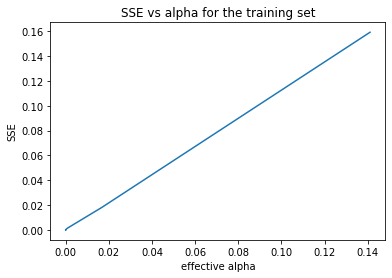

In [94]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, SSE)
ax.set_xlabel('effective alpha')
ax.set_ylabel('SSE')
ax.set_title('SSE vs alpha for the training set');

In [95]:
def fit_tree(alpha):
    tr = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    tr.fit(X_train, y_train)
    return(tr)
with Pool(processes = 7) as p:
    trees = p.map(fit_tree,ccp_alphas)

In [96]:
data = []
for tr in trees:
    alpha = tr.ccp_alpha
    acc_tr = tr.score(X_train,y_train)
    acc_va = tr.score(X_val,y_val)
    n_leaves = tr.get_n_leaves()
    depth = tr.get_depth()
    data.append({'alpha':alpha,'depth':depth,'n_leaves':n_leaves,
                 'acc_tr':acc_tr,'acc_va':acc_va})
df_acc = pd.DataFrame(data)
sorted_df = df_acc.sort_values(by='acc_va',ascending = False)
sorted_df

,alpha,depth,n_leaves,acc_tr,acc_va
7,5.516825e-05,5,6,0.999509,0.996036
6,1.125883e-05,5,7,0.999856,0.994888
3,1.200942e-06,6,10,0.999992,0.994711
0,0.000000e+00,7,13,1.000000,0.994573
1,6.479901e-19,6,12,1.000000,0.994573
2,6.479901e-18,6,11,1.000000,0.994573
4,1.441130e-06,6,9,0.999983,0.994533
5,9.007062e-06,5,8,0.999927,0.994505
8,2.579295e-04,4,5,0.997889,0.994168
9,2.604096e-04,3,4,0.996253,0.992293


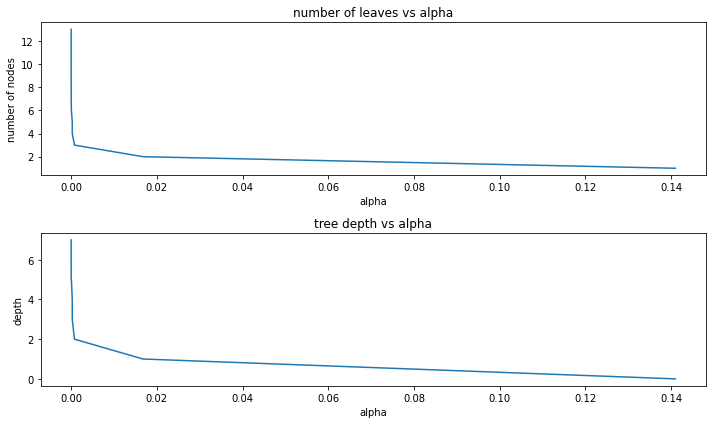

In [97]:
fig, ax = plt.subplots(2, 1,figsize = (10,6))
ax[0].plot(df_acc.alpha, df_acc.n_leaves)
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of nodes')
ax[0].set_title('number of leaves vs alpha')
ax[1].plot(df_acc.alpha, df_acc.depth)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('depth')
ax[1].set_title('tree depth vs alpha')
fig.tight_layout();

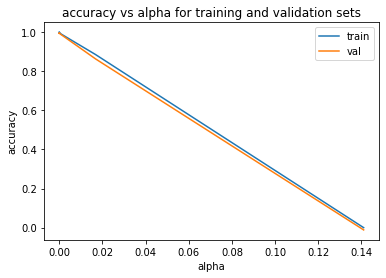

In [98]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs alpha for training and validation sets')
ax.plot(df_acc.alpha, df_acc.acc_tr, label='train')
ax.plot(df_acc.alpha, df_acc.acc_va, label='val')
# ax.set_xlim(-10**5,10**8)
ax.legend()
plt.show()

In [99]:
best_idx = df_acc['acc_va'].idxmax()
best_row = df_acc.loc[best_idx]
best_row

alpha       0.000055
depth       5.000000
n_leaves    6.000000
acc_tr      0.999509
acc_va      0.996036
Name: 7, dtype: float64

In [100]:
trees[best_idx].score(X_test,y_test)

0.8261377605254608

In [101]:
#define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
X = df2[final_features_fatality]
#X = df2[feature_columns_shooter_orig]


y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Initialize the Random Forest model
# Initialize the Decision Tree model
# Set hyperparameters for pruning the tree
dt_model = DecisionTreeRegressor(
    max_depth=5,  # Maximum depth of the tree (you can experiment with different values)
    max_leaf_nodes = 7,
    random_state=0,  # Random state for reproducibility
)

# Train the Decision Tree model using the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_val_pred = dt_model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_val_pred)

val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation R-squared (R^2): {val_r2:.4f}')

# Print the mean squared error
print(f'Val Mean Squared Error: {mse:.4f}')

Validation R-squared (R^2): 0.9856
Val Mean Squared Error: 0.0019


In [102]:
target_column = 'Shooter_Killed'  

# Split data into features (X) and target (y)
X = df2[final_features_shooter]
#X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

In [103]:
tr = DecisionTreeClassifier(random_state=0)
path = tr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, SSE = path.ccp_alphas, path.impurities

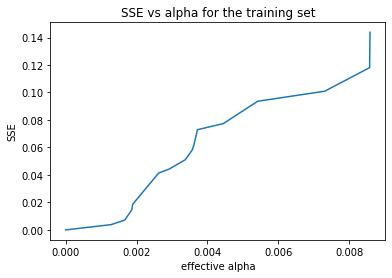

In [104]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, SSE)
ax.set_xlabel('effective alpha')
ax.set_ylabel('SSE')
ax.set_title('SSE vs alpha for the training set');

In [105]:
def fit_tree(alpha):
    tr = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tr.fit(X_train, y_train)
    return(tr)
with Pool(processes = 7) as p:
    trees = p.map(fit_tree,ccp_alphas)

In [106]:
data = []
for tr in trees:
    alpha = tr.ccp_alpha
    acc_tr = tr.score(X_train,y_train)
    acc_va = tr.score(X_val,y_val)
    n_leaves = tr.get_n_leaves()
    depth = tr.get_depth()
    data.append({'alpha':alpha,'depth':depth,'n_leaves':n_leaves,
                 'acc_tr':acc_tr,'acc_va':acc_va})
df_acc = pd.DataFrame(data)
sorted_df = df_acc.sort_values(by='acc_va',ascending = True)
sorted_df

,alpha,depth,n_leaves,acc_tr,acc_va
0,0.000000,10,40,1.000000,0.859086
2,0.001668,10,35,0.996109,0.864917
1,0.001283,10,37,0.998054,0.865889
3,0.001866,10,31,0.992218,0.869776
4,0.001888,10,29,0.990272,0.871720
5,0.001946,10,28,0.988327,0.871720
8,0.003372,8,17,0.972763,0.880466
7,0.002918,8,19,0.976654,0.881438
6,0.002622,8,20,0.978599,0.881438
9,0.003570,8,15,0.968872,0.882410


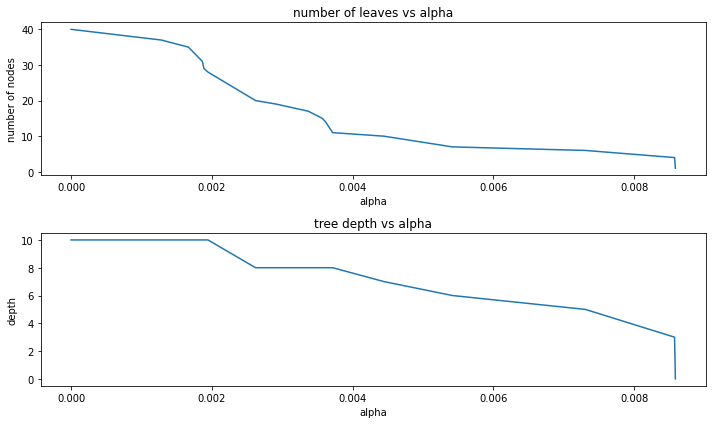

In [107]:
fig, ax = plt.subplots(2, 1,figsize = (10,6))
ax[0].plot(df_acc.alpha, df_acc.n_leaves)
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of nodes')
ax[0].set_title('number of leaves vs alpha')
ax[1].plot(df_acc.alpha, df_acc.depth)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('depth')
ax[1].set_title('tree depth vs alpha')
fig.tight_layout();

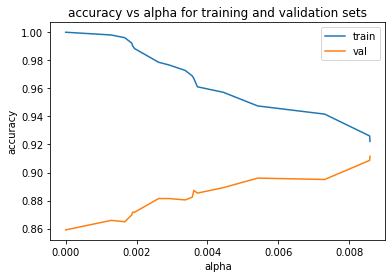

In [108]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs alpha for training and validation sets')
ax.plot(df_acc.alpha, df_acc.acc_tr, label='train')
ax.plot(df_acc.alpha, df_acc.acc_va, label='val')
# ax.set_xlim(-10**5,10**8)
ax.legend()
plt.show()

In [109]:
best_idx = df_acc['acc_va'].idxmax()
best_row = df_acc.loc[best_idx]
best_row

alpha       0.008586
depth       0.000000
n_leaves    1.000000
acc_tr      0.922179
acc_va      0.911565
Name: 16, dtype: float64

In [110]:
trees[best_idx].score(X_test,y_test)

0.8960155490767736

In [111]:
target_column = 'Shooter_Killed'  # Replace 'your_target_column' with the name of your target column


X = df2[final_features_shooter]
#X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# Initialize the Decision Tree model
# Set hyperparameters for pruning the tree
dt_model = DecisionTreeClassifier(
    max_depth=10,  
    #max_leaf_nodes = 35,
    random_state=0,
    class_weight=dict(enumerate(class_weights))
    
)

# Train the Decision Tree model using the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_val_pred = dt_model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_val_pred)

val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the validation accuracy score
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Print the mean squared error
print(f'Val Mean Squared Error: {mse:.4f}')

Validation Accuracy: 0.8230
Val Mean Squared Error: 0.1829


/home/jklingl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=5       0
55      0
1116    0
987     0
511     0
       ..
1033    0
1731    0
763     0
835     0
1653    1
Name: Shooter_Killed, Length: 1543, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## XGBoost Model

In [112]:
#define the dependent (target) variable
target_column = '%_Fatality'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
X = df2[final_features_fatality]
#X = df2[feature_columns_per_fatality_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees in the model
    max_depth=6,  # Maximum depth of each tree
    learning_rate=0.1,  
    random_state=0  # Random state for reproducibility
)

# Train the XGBoost model using the training data
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)


# Make predictions on the test set
y_val_pred = xgb_model.predict(X_val)

# Calculate mean squared error
mse = mean_squared_error(y_val, y_val_pred)

val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation R-squared (R^2): {val_r2:.4f}')

# Print the mean squared error
print(f'Val Mean Squared Error: {mse:.4f}')

[0]	validation_0-rmse:0.43812
[1]	validation_0-rmse:0.39480
[2]	validation_0-rmse:0.35583
[3]	validation_0-rmse:0.32079
[4]	validation_0-rmse:0.28951
[5]	validation_0-rmse:0.26115
[6]	validation_0-rmse:0.23576
[7]	validation_0-rmse:0.21281
[8]	validation_0-rmse:0.19240
[9]	validation_0-rmse:0.17406
[10]	validation_0-rmse:0.15774
[11]	validation_0-rmse:0.14297
[12]	validation_0-rmse:0.12975
[13]	validation_0-rmse:0.11805
[14]	validation_0-rmse:0.10757
[15]	validation_0-rmse:0.09817
[16]	validation_0-rmse:0.09001
[17]	validation_0-rmse:0.08259
[18]	validation_0-rmse:0.07608
[19]	validation_0-rmse:0.06985
[20]	validation_0-rmse:0.06418
[21]	validation_0-rmse:0.05931
[22]	validation_0-rmse:0.05478
[23]	validation_0-rmse:0.05079
[24]	validation_0-rmse:0.04743
[25]	validation_0-rmse:0.04434
[26]	validation_0-rmse:0.04185
[27]	validation_0-rmse:0.03990
[28]	validation_0-rmse:0.03808
[29]	validation_0-rmse:0.03647
[30]	validation_0-rmse:0.03508
[31]	validation_0-rmse:0.03389
[32]	validation_0-

In [113]:
#define the dependent (target) variable
target_column = 'Shooter_Killed'  # Replace 'your_target_column' with the name of your target column


# Split data into features (X) and target (y)
#X = df2[final_features_shooter]
X = df2[feature_columns_shooter_orig]

y = df2[target_column]

# splitting train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# split test into val/test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)


# Initialize the XGBoost regressor
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees in the model
    max_depth=6,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate (shrinkage)
    random_state=0,  # Random state for reproducibility
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1)  # scale_pos_weight adjustment
    
)

# Compute class weights for sample_weight
sample_weights = np.array([class_weights[int(label)] for label in y_train])

# Train the XGBoost model with sample weights
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], sample_weight=sample_weights, early_stopping_rounds=10, verbose=True)

# Make predictions on the validation set with sample weights
y_val_pred_weighted = xgb_model.predict(X_val)

# Calculate accuracy score with sample weights
accuracy_weighted = accuracy_score(y_val, y_val_pred_weighted)

# Print the accuracy score with sample weights
print(f'Validation Accuracy (with Sample Weights): {accuracy_weighted:.4f}')

mse_weighted = mean_squared_error(y_val, y_val_pred_weighted)

# Print the mean squared error with sample weights
print(f'Validation Mean Squared Error (with Sample Weights): {mse_weighted:.4f}')

[19:49:30] WARNING: ../src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:49:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.00798
[1]	validation_0-mlogloss:0.93498
[2]	validation_0-mlogloss:0.86887
[3]	validation_0-mlogloss:0.81437
[4]	validation_0-mlogloss:0.76578
[5]	validation_0-mlogloss:0.72318
[6]	validation_0-mlogloss:0.68584


/home/jklingl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=5       0
55      0
1116    0
987     0
511     0
       ..
1033    0
1731    0
763     0
835     0
1653    1
Name: Shooter_Killed, Length: 1543, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/jklingl/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-mlogloss:0.65128
[8]	validation_0-mlogloss:0.62139
[9]	validation_0-mlogloss:0.59518
[10]	validation_0-mlogloss:0.57122
[11]	validation_0-mlogloss:0.54923
[12]	validation_0-mlogloss:0.52995
[13]	validation_0-mlogloss:0.51146
[14]	validation_0-mlogloss:0.49515
[15]	validation_0-mlogloss:0.48180
[16]	validation_0-mlogloss:0.46783
[17]	validation_0-mlogloss:0.45569
[18]	validation_0-mlogloss:0.44465
[19]	validation_0-mlogloss:0.43488
[20]	validation_0-mlogloss:0.42564
[21]	validation_0-mlogloss:0.41808
[22]	validation_0-mlogloss:0.40962
[23]	validation_0-mlogloss:0.40189
[24]	validation_0-mlogloss:0.39508
[25]	validation_0-mlogloss:0.38859
[26]	validation_0-mlogloss:0.38303
[27]	validation_0-mlogloss:0.37748
[28]	validation_0-mlogloss:0.37231
[29]	validation_0-mlogloss:0.36717
[30]	validation_0-mlogloss:0.36285
[31]	validation_0-mlogloss:0.35909
[32]	validation_0-mlogloss:0.35521
[33]	validation_0-mlogloss:0.35242
[34]	validation_0-mlogloss:0.34863
[35]	validation_0-mlogl